# docs

In [1]:
#!/usr/bin/env python

__author__ = "Sushil Sivaram", "Megha Gubbala", "Sylvia Nanyangwe"
__copyright__ = "N/A"
__credits__ = ["Isac Artzi", "Dinesh Sthapit", "Ken Ferrell", "James Dzikunu", "Tracy Roth", "Renee Morales"]
__license__ = "ECL"
__maintainer__ = "Sushil Sivaram", "Megha Gubbala", "Sylvia Nanyangwe"
__email__ = "SushilSivaram@gmail.com"
__status__ = "Development"

# This section shows the imports used by the code

In [2]:
from matplotlib import pyplot
from scipy import stats
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.features import Rank2D
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import scikitplot as skplt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import balanced_accuracy_score
from IPython.display import Markdown
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


# Define Variables

In [3]:
load_dotenv()
#CSVData = os.getenv('CSVOriginal')
CSVData = 'food_afford_cdp_co_region_ca4-14-13-ada.csv'
DependentVariable = os.getenv('DependentVariable')
head_Value = int(os.getenv('Head_Value'))
testSize = float(os.getenv('test_size'))
randomstate = int(os.getenv('random_state'))
dataSetUp = []
keepcolumns = ['race_eth_code', 'median_income', 'affordability_ratio', 'ave_fam_size']
datasetupUnprocessed = []

# Setup Reusable Functions

In [4]:
# Load Data from CSV
def loadAndExtractData():
    def readCSV():
        global datasetupUnprocessed
        dataSetUp = pd.read_csv(CSVData)
        datasetupUnprocessed = dataSetUp
        display(datasetupUnprocessed.corr())
        dataout = datasetupUnprocessed.corr()
        dataout.to_csv('dataout.csv')
        display(FileLink('dataout.csv'))
        return dataSetUp

    def dropVariables():
        dataSetUp = readCSV()
        dataSetUp = dataSetUp.filter(keepcolumns)
        return dataSetUp

    def removeNullValues():
        dataSetUp = dropVariables()
        for keep in keepcolumns:
            dataSetUp = dataSetUp[dataSetUp[keep].notna()]
        return dataSetUp

    def removeOutliers():
        global dataSetUp
        dataSetUp = removeNullValues()
        dataSetUp = dataSetUp[(np.abs(stats.zscore(dataSetUp)) < 3).all(axis=1)]
        dataSetUp.to_csv('cleaned.csv', index=False)
        print(FileLink('cleaned.csv'))
        print(dataSetUp.shape)
        return dataSetUp
    dataSetUp = removeOutliers()        


# print Info
def showDataHeadAndInfo(data, headCount):
    print(f"showing head {headCount} values")
    print(data.head(headCount))
    print("**********")
    print("Showing info of dataset")
    print(data.describe(include='all'))


# preProcessing
def preProcessing():
    bins = (0, .2, 5)
    group_names = ['Cant Afford', 'Can Afford']
    dataSetUp[DependentVariable] = pd.cut(dataSetUp[DependentVariable], bins, labels=group_names)
    dataSetUp.to_csv('test.csv')
    label_quality = LabelEncoder()
    dataSetUp[DependentVariable] = label_quality.fit_transform(dataSetUp[DependentVariable])
    # showDataHeadAndInfo(head_Value)
    print(dataSetUp[DependentVariable].value_counts())


# plotting
def plotting(dataSetUp, state):
    plt.figure()
    histmedian_income = dataSetUp['median_income'].plot.hist(bins=25, grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram of Median Income {state}')
    plt.xlabel('Median Income in $')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    histmedian_income.figure.savefig(f'.\outputs\histMedianIncome{state}.png')

    plt.figure()
    hist_avg_fam = dataSetUp['ave_fam_size'].plot.hist(bins=25, grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram of Family Size {state}')
    plt.xlabel('Family Size')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    hist_avg_fam.figure.savefig(f'.\outputs\histavgFamsize{state}.png')

    plt.figure()
    hist_race_eth_name = dataSetUp['race_eth_code'].plot.hist(bins=2, grid=True, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram race distribution {state}')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    hist_race_eth_name.figure.savefig(f'.\outputs\histCost{state}.png')

    plt.figure()
    scattermedian_income = dataSetUp.plot.scatter(c='DarkBlue', x='median_income', y='ave_fam_size')
    plt.title(f'scatterogram of Median Income vs Expenditure {state}')
    plt.xlabel('Median Income in $')
    plt.ylabel('ave_fam_size')
    plt.grid(axis='y', alpha=0.5)
    scattermedian_income.figure.savefig(f'.\outputs\scatterMedianIncomeVSFamilySize{state}.png')
    plt.figure()
    
#Variable importance
def checkforPCA():
    #dataSetUp = removeOutliers()
    pca = PCA()
    X = dataSetUp.drop(DependentVariable, axis=1)
    y = dataSetUp[DependentVariable]
    x_pca = pca.fit_transform(X)
    x_pca = pd.DataFrame(x_pca)
    datapca = x_pca.head()
    datapca.to_csv('datapca.csv')
    print(FileLink('datapca.csv'))
    return dataSetUp  

def predictorImportance():
    X = dataSetUp.drop(DependentVariable, axis=1)
    y = dataSetUp[DependentVariable]
    model = LogisticRegression()
    # fit the model
    model.fit(X, y)
    importance = model.coef_[0]
    # summarize feature importance
    for i, v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i, v))
    # plot feature importance
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.show()


def vifCheck(dataSetUp):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataSetUp.columns
    vif_data["VIF"] = [variance_inflation_factor(dataSetUp.values, i)
                       for i in range(len(dataSetUp.columns))]
    print(vif_data)

    
def rocChart():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    predicted_probas = nb.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, predicted_probas)
    plt.show()


# Training
def trainDataset():
    global X_train
    global y_train
    global X_test
    global y_test
    global sc
    # Train and test with random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randomstate)
    # Optimizing with standardScaler to minimize bias and normalize values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

# Load Data from CSV

In [5]:
loadAndExtractData()

,race_eth_code,geotypevalue,county_fips,region_code,cost_yr,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,se_food_afford,rse_food_afford,food_afford_decile,CA_RR_Affordability,ave_fam_size
race_eth_code,1.000000e+00,3.708010e-15,6.726802e-16,2.879208e-16,1.984846e-16,0.016844,-0.018701,0.066166,0.000871,0.001582,-0.024788,NaN,-0.018701,2.152639e-16
geotypevalue,3.708010e-15,1.000000e+00,7.375404e-02,5.456655e-02,4.041370e-02,0.055404,0.017357,-0.045863,0.013320,0.015093,0.035105,0.005215,0.017357,3.332340e-02
county_fips,6.726802e-16,7.375404e-02,1.000000e+00,1.334657e-01,-6.613978e-02,-0.027582,0.038356,-0.030209,-0.000084,0.001011,0.000977,-0.016812,0.038356,-5.812496e-02
region_code,2.879208e-16,5.456655e-02,1.334657e-01,1.000000e+00,2.819355e-01,-0.081700,0.073701,0.115173,-0.001915,-0.008380,-0.040371,-0.155385,0.073701,2.176299e-01
cost_yr,1.984846e-16,4.041370e-02,-6.613978e-02,2.819355e-01,1.000000e+00,-0.091045,0.135295,0.236318,-0.013875,-0.031320,-0.077387,-0.355870,0.135295,9.636004e-01
median_income,1.684375e-02,5.540431e-02,-2.758242e-02,-8.170001e-02,-9.104477e-02,1.000000,-0.443224,-0.301998,-0.207914,-0.168264,-0.134449,0.728487,-0.443224,-1.722281e-01
affordability_ratio,-1.870110e-02,1.735681e-02,3.835569e-02,7.370095e-02,1.352948e-01,-0.443224,1.000000,0.188805,0.540766,0.482920,0.337438,-0.619112,1.000000,1.797588e-01
LL95_affordability_ratio,6.616617e-02,-4.586301e-02,-3.020901e-02,1.151732e-01,2.363179e-01,-0.301998,0.188805,1.000000,-0.114302,-0.134097,-0.276530,-0.404021,0.188805,2.685427e-01
UL95_affordability_ratio,8.708342e-04,1.331955e-02,-8.442782e-05,-1.914618e-03,-1.387481e-02,-0.207914,0.540766,-0.114302,1.000000,0.997732,0.865031,-0.218592,0.540766,2.624772e-03
se_food_afford,1.581582e-03,1.509296e-02,1.011063e-03,-8.380012e-03,-3.132043e-02,-0.168264,0.482920,-0.134097,0.997732,1.000000,0.873499,-0.175208,0.482920,-1.918185e-02


C:\Project\Capstone\dataout.csv

C:\Project\Capstone\cleaned.csv
(3216, 4)


check for PCA

In [6]:
checkforPCA()

C:\Project\Capstone\datapca.csv


,race_eth_code,median_income,affordability_ratio,ave_fam_size
0,1.0,23777.0,0.315779,3.34
1,2.0,38508.0,0.194980,3.34
2,3.0,26192.0,0.286664,3.34
3,4.0,22858.0,0.328475,3.34
4,5.0,36737.0,0.204379,3.34
...,...,...,...,...
14223,4.0,13233.0,0.575954,3.21
14225,6.0,19381.0,0.393251,3.21
14228,9.0,18893.0,0.403409,3.21
14234,6.0,67813.0,0.109646,3.07


# Print Info

In [7]:
showDataHeadAndInfo(datasetupUnprocessed,head_Value)

showing head 15 values
   ind_id                                     ind_definition reportyear  \
0     757  Food affordability for female-headed household...  2006-2010   
1     757  Food affordability for female-headed household...  2006-2010   
2     757  Food affordability for female-headed household...  2006-2010   
3     757  Food affordability for female-headed household...  2006-2010   
4     757  Food affordability for female-headed household...  2006-2010   
5     757  Food affordability for female-headed household...  2006-2010   
6     757  Food affordability for female-headed household...  2006-2010   
7     757  Food affordability for female-headed household...  2006-2010   
8     757  Food affordability for female-headed household...  2006-2010   
9     757  Food affordability for female-headed household...  2006-2010   
10    757  Food affordability for female-headed household...  2006-2010   
11    757  Food affordability for female-headed household...  2006-2010   
12

# Exploratory plotting

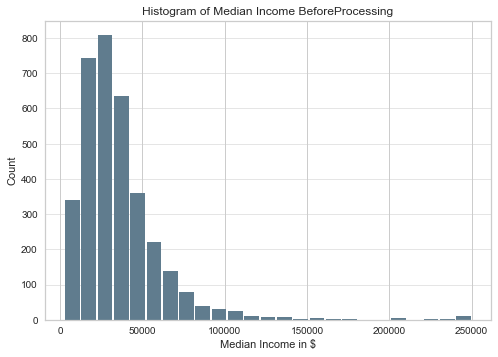

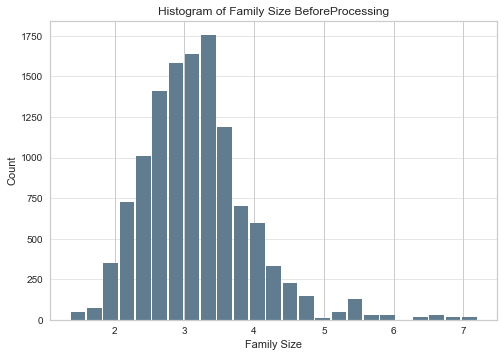

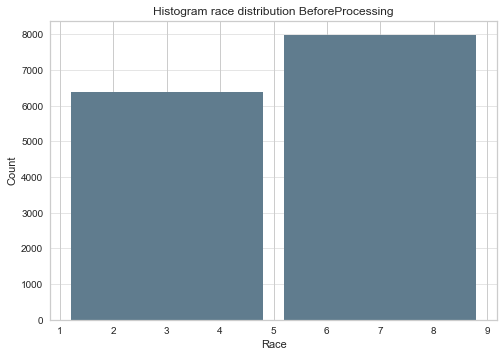

<Figure size 576x396 with 0 Axes>

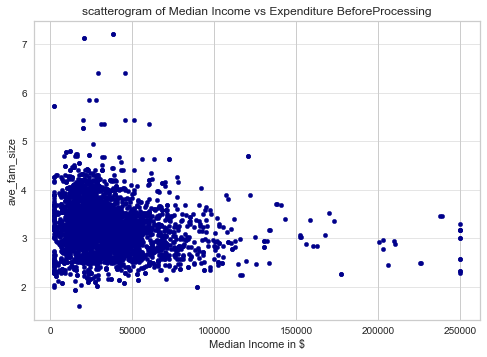

<Figure size 576x396 with 0 Axes>

In [8]:
plotting(datasetupUnprocessed , "BeforeProcessing")

# preProcessing

In [9]:
preProcessing()
showDataHeadAndInfo(dataSetUp,head_Value)


0    1997
1    1219
Name: affordability_ratio, dtype: int64
showing head 15 values
    race_eth_code  median_income  affordability_ratio  ave_fam_size
0             1.0        23777.0                    0          3.34
1             2.0        38508.0                    1          3.34
2             3.0        26192.0                    0          3.34
3             4.0        22858.0                    0          3.34
4             5.0        36737.0                    0          3.34
5             6.0        38641.0                    1          3.34
6             7.0        32866.0                    0          3.34
7             8.0        30439.0                    0          3.34
8             9.0        28184.0                    0          3.34
9             1.0        16063.0                    0          3.21
10            2.0        42048.0                    1          3.21
11            3.0        23858.0                    0          3.21
12            4.0        28917.0 

# Plotting post Cleanup

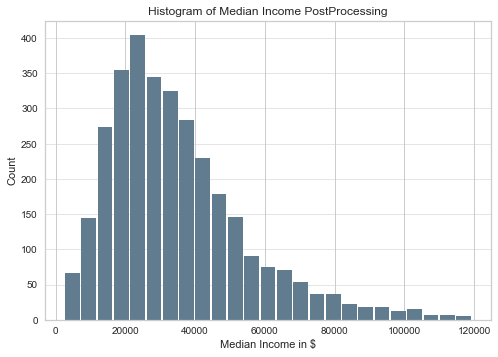

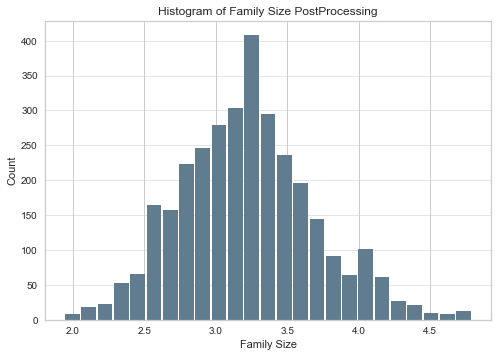

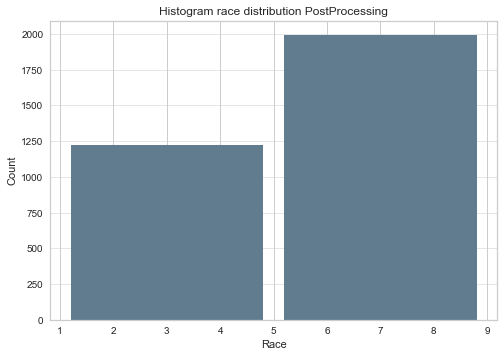

<Figure size 576x396 with 0 Axes>

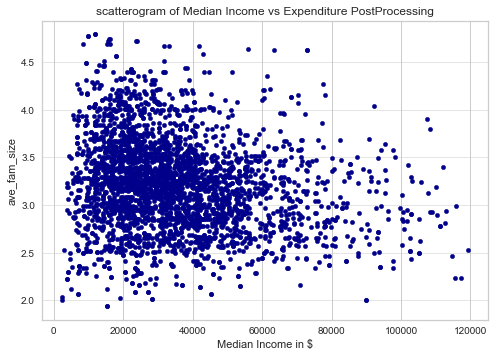

<Figure size 576x396 with 0 Axes>

In [10]:
plotting(dataSetUp, "PostProcessing")

Check Corellation

In [11]:
dataSetUp.corr()

,race_eth_code,median_income,affordability_ratio,ave_fam_size
race_eth_code,1.000000,-0.002623,0.018847,-0.078065
median_income,-0.002623,1.000000,0.762884,-0.208589
affordability_ratio,0.018847,0.762884,1.000000,-0.357839
ave_fam_size,-0.078065,-0.208589,-0.357839,1.000000


# Check VIF

In [12]:
vifCheck(dataSetUp)

               feature       VIF
0        race_eth_code  5.828060
1        median_income  9.711446
2  affordability_ratio  4.136264
3         ave_fam_size  8.492811


# Predictor Importance

Feature: 0, Score: 0.00621
Feature: 1, Score: 0.00073
Feature: 2, Score: -7.73580


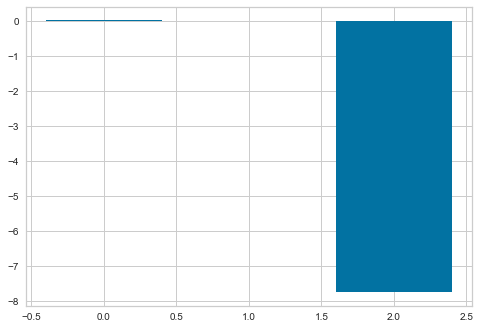

In [13]:
predictorImportance()

# separate dependent and independent variables

In [14]:
X = dataSetUp.drop(DependentVariable, axis=1)
y = dataSetUp[DependentVariable]

# Pearsons Analysis

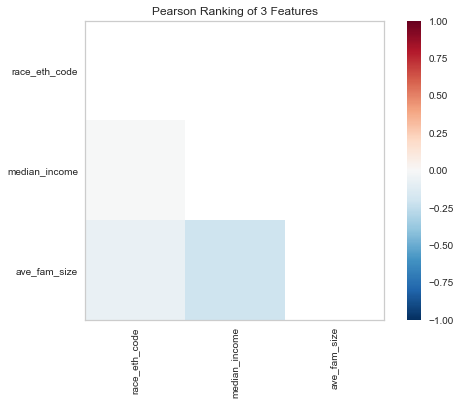

<AxesSubplot:title={'center':'Pearson Ranking of 3 Features'}>

In [15]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

# ClassBalance 

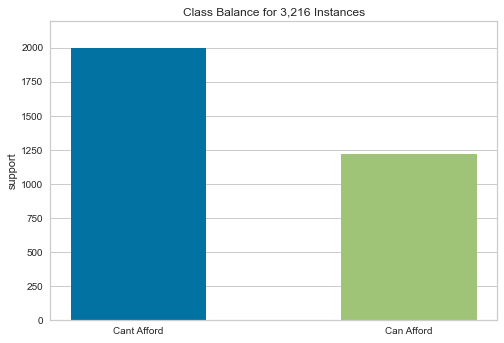

<AxesSubplot:title={'center':'Class Balance for 3,216 Instances'}, ylabel='support'>

In [16]:
visualizer = ClassBalance(labels=["Cant Afford", "Can Afford"])
visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Split Dataset into train and test dataset

In [17]:
trainDataset()

# Create a dict of models to use

In [18]:
dict_classifiers = {
    "rfc": RandomForestClassifier(n_estimators=200),
    "clf": svm.SVC(),
    "mlpc": MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=500,  random_state=1),
    "lr": LogisticRegression(),
}

# Train and Print Details

<h2 span style="color: #2A52bE; font-size:150%">Model Evaluation RandomForestClassifier(n_estimators=200)</span>


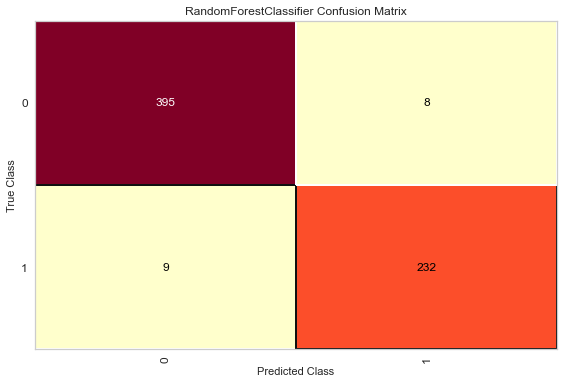

<span style="color: #2A52bE">Classification Report
</span>

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       403
           1       0.97      0.96      0.96       241

    accuracy                           0.97       644
   macro avg       0.97      0.97      0.97       644
weighted avg       0.97      0.97      0.97       644


<span style="color: #2A52bE">Accuracy Rate = </span>0.9736024844720497

<span style="color: #2A52bE">Error Rate = </span>0.026397515527950333

<span style="color: #2A52bE">Root Mean Square Error = </span>0.026397515527950312


<span style="color: #2A52bE">Specificity = </span>0.9801488833746899

<span style="color: #2A52bE">Sensitivity = </span>0.9626556016597511

<span style="color: #2A52bE">Balance Accuracy = </span>0.9714022425172204


<span style="color: #2A52bE">Precision = </span>0.9666666666666667


<span style="color: #2A52bE">Recall = </span>0.9626556016597511


<span style="color: #2A52bE">F1 Score = </span>0.9646569646569647


Average precision-recall score: 0.94


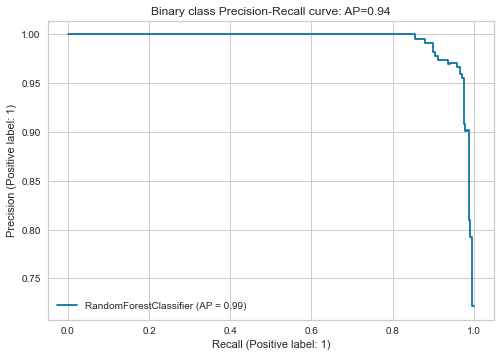

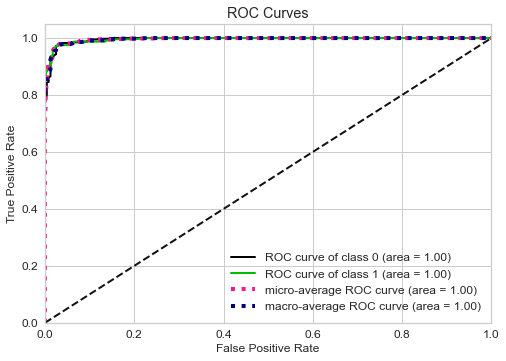

<h2 span style="color: #2A52bE; font-size:150%">Model Evaluation SVC()</span>


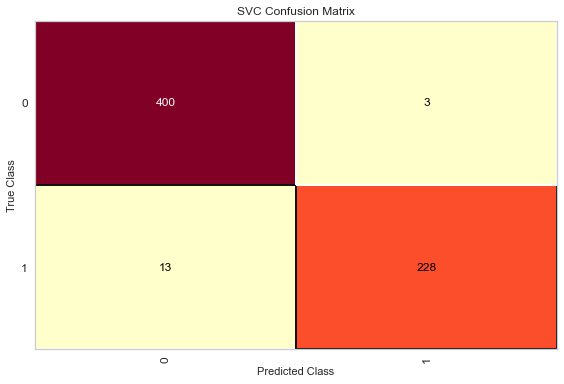

<span style="color: #2A52bE">Classification Report
</span>

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       403
           1       0.99      0.95      0.97       241

    accuracy                           0.98       644
   macro avg       0.98      0.97      0.97       644
weighted avg       0.98      0.98      0.98       644


<span style="color: #2A52bE">Accuracy Rate = </span>0.9751552795031055

<span style="color: #2A52bE">Error Rate = </span>0.024844720496894457

<span style="color: #2A52bE">Root Mean Square Error = </span>0.024844720496894408


<span style="color: #2A52bE">Specificity = </span>0.9925558312655087

<span style="color: #2A52bE">Sensitivity = </span>0.946058091286307

<span style="color: #2A52bE">Balance Accuracy = </span>0.9693069612759079


<span style="color: #2A52bE">Precision = </span>0.987012987012987


<span style="color: #2A52bE">Recall = </span>0.946058091286307


<span style="color: #2A52bE">F1 Score = </span>0.9661016949152542


Average precision-recall score: 0.95


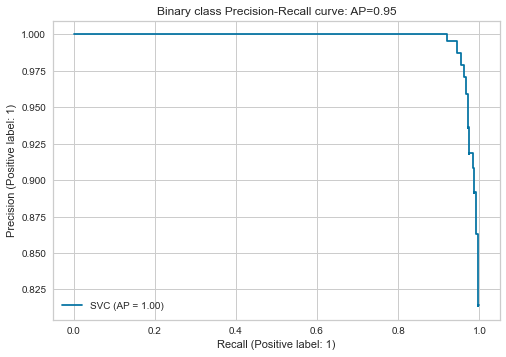

ROC unavailable for SVC()


<h2 span style="color: #2A52bE; font-size:150%">Model Evaluation MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=500, random_state=1)</span>


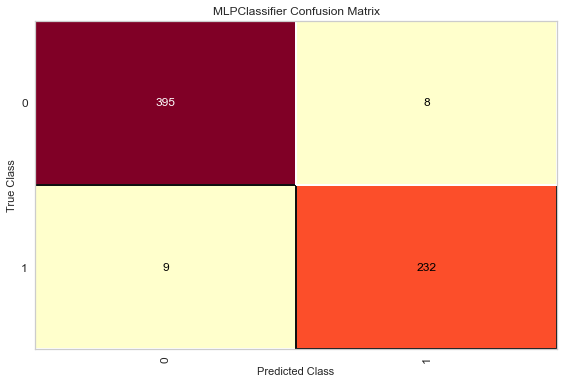

<span style="color: #2A52bE">Classification Report
</span>

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       403
           1       0.97      0.96      0.96       241

    accuracy                           0.97       644
   macro avg       0.97      0.97      0.97       644
weighted avg       0.97      0.97      0.97       644


<span style="color: #2A52bE">Accuracy Rate = </span>0.9736024844720497

<span style="color: #2A52bE">Error Rate = </span>0.026397515527950333

<span style="color: #2A52bE">Root Mean Square Error = </span>0.026397515527950312


<span style="color: #2A52bE">Specificity = </span>0.9801488833746899

<span style="color: #2A52bE">Sensitivity = </span>0.9626556016597511

<span style="color: #2A52bE">Balance Accuracy = </span>0.9714022425172204


<span style="color: #2A52bE">Precision = </span>0.9666666666666667


<span style="color: #2A52bE">Recall = </span>0.9626556016597511


<span style="color: #2A52bE">F1 Score = </span>0.9646569646569647


Average precision-recall score: 0.94


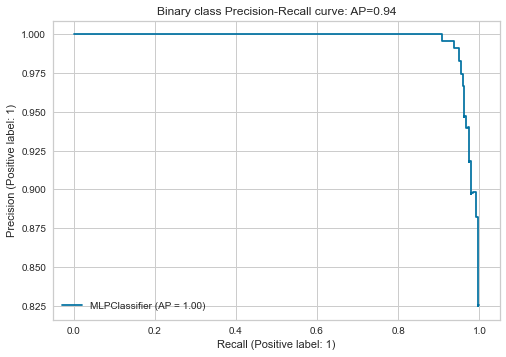

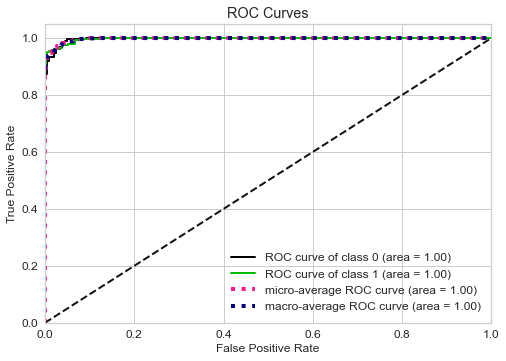

<h2 span style="color: #2A52bE; font-size:150%">Model Evaluation LogisticRegression()</span>


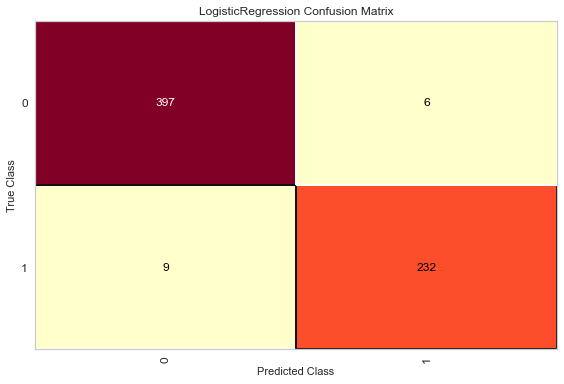

<span style="color: #2A52bE">Classification Report
</span>

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       403
           1       0.97      0.96      0.97       241

    accuracy                           0.98       644
   macro avg       0.98      0.97      0.98       644
weighted avg       0.98      0.98      0.98       644


<span style="color: #2A52bE">Accuracy Rate = </span>0.9767080745341615

<span style="color: #2A52bE">Error Rate = </span>0.02329192546583847

<span style="color: #2A52bE">Root Mean Square Error = </span>0.023291925465838508


<span style="color: #2A52bE">Specificity = </span>0.9851116625310173

<span style="color: #2A52bE">Sensitivity = </span>0.9626556016597511

<span style="color: #2A52bE">Balance Accuracy = </span>0.9738836320953842


<span style="color: #2A52bE">Precision = </span>0.9747899159663865


<span style="color: #2A52bE">Recall = </span>0.9626556016597511


<span style="color: #2A52bE">F1 Score = </span>0.9686847599164927


Average precision-recall score: 0.95


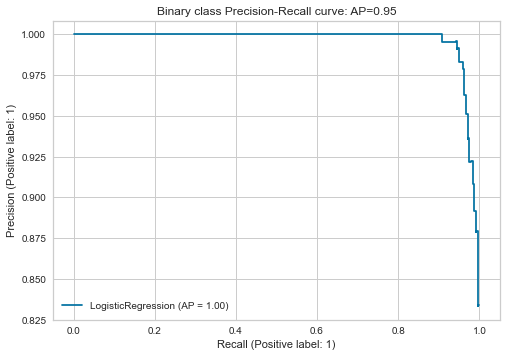

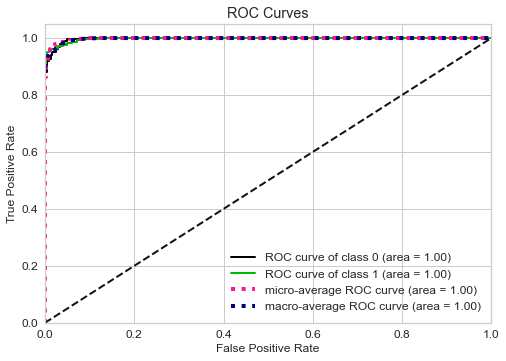

In [19]:
for model, model_instantiation in dict_classifiers.items():
    model = model_instantiation
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    # yellow brick
    cm = ConfusionMatrix(model, classes=[0,1])
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    
    confusion_Matrix = confusion_matrix(y_test, y_score)
    
    
    display (Markdown(f'<h2 span style="color: #2A52bE; font-size:150%">Model Evaluation {model}</span>\n'))
    #print(f"Printing Model details for : {model}\n")          
    cm.show()
    cm = accuracy_score(y_test, y_score)
    errorRate = 1-cm    
    tn, fp, fn, tp = confusion_matrix(y_test, y_score).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn) 
    #Precision is defined as the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class.
    precision = tp / (tp + fp)
    
    #Recall is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class.
    recall = tp/(tp+fn)
    
    F1 = 2 * (precision * recall) / (precision + recall)
    average_precision = average_precision_score(y_test, y_score)
    
    rmse=mean_squared_error(y_test, y_score)

    
    
    bs=balanced_accuracy_score(y_test, y_score)
    display (Markdown(f'<span style="color: #2A52bE">Classification Report\n</span>'))    
    display (Markdown(f'{classification_report(y_test, y_score)}'))
    print('\n')
    #print(f"Printing Classification Report\n {classification_report(y_test, y_score)}\n")
    #display (Markdown(f'<span style="color: #00FF00">Classification Report \n </span>{classification_report(y_test, y_score)}'))
    display (Markdown(f'<span style="color: #2A52bE">Accuracy Rate = </span>{cm}'))
    display (Markdown(f'<span style="color: #2A52bE">Error Rate = </span>{errorRate}'))
    display (Markdown(f'<span style="color: #2A52bE">Root Mean Square Error = </span>{rmse}\n'))
    display (Markdown(f'<span style="color: #2A52bE">Specificity = </span>{specificity}'))
    display (Markdown(f'<span style="color: #2A52bE">Sensitivity = </span>{sensitivity}'))
    display (Markdown(f'<span style="color: #2A52bE">Balance Accuracy = </span>{bs}\n'))
    display (Markdown(f'<span style="color: #2A52bE">Precision = </span>{precision}\n'))
    display (Markdown(f'<span style="color: #2A52bE">Recall = </span>{recall}\n'))
    display (Markdown(f'<span style="color: #2A52bE">F1 Score = </span>{F1}\n'))
    
    
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))    
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    pyplot.show()
  
    try:
        predicted_probas = model.predict_proba(X_test)
        skplt.metrics.plot_roc(y_test, predicted_probas)
        plt.show()
    except:
        print(f"ROC unavailable for {model}")

    


# Plot ROC Chart

In [20]:
#rocChart()

# Predictive Analysis

In [21]:
mlpc = MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=500,  random_state=randomstate)
mlpc.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=500, random_state=7)

# test first item in test data

In [22]:
Xnew = X_test[[0]]
pred_mlpc = mlpc.predict(X_test)
ynew = mlpc.predict(Xnew)
if ynew == 0:
    print(f"I am too poor to afford food")
else:
    print(f"I will survive")

I am too poor to afford food


# Set up variables for adhoc test (User Configurable)

In [23]:
ynew = 0 # Do not Change
income = 20000
famSize = 3
raceIndicator = 9

 # 0 - Non White / 1 - White
IncomeIncreaseIterator = 50 # value used to fine tune income increase
Xnew = [[raceIndicator, income, famSize]]
Xnew1 = sc.transform(Xnew)

# Define Iterator

In [24]:
while ynew == 0:
    Xnew1 = sc.transform(Xnew)
    ynew = mlpc.predict(Xnew1)
    print(f'new ynew: {ynew} for xnew: {Xnew}')
    if ynew == 1:
        print(f"VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV You will Be fine at current cost below "
              f"VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV")
        break
    else:
        income=income+IncomeIncreaseIterator
        print(f"HMM you need to earn more iterating to find you an optimal amount trying {Xnew} ")
        Xnew = [[raceIndicator, income , famSize]]
        Xnew1 = sc.transform(Xnew)
        ynew = mlpc.predict(Xnew1)

print(f"***********************************************-- "
      f"We suggest you earn ${Xnew[0][1]} for family counts of {Xnew[0][2]} "
      f" --***********************************************")


new ynew: [0] for xnew: [[9, 20000, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20000, 3]] 
new ynew: [0] for xnew: [[9, 20050, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20050, 3]] 
new ynew: [0] for xnew: [[9, 20100, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20100, 3]] 
new ynew: [0] for xnew: [[9, 20150, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20150, 3]] 
new ynew: [0] for xnew: [[9, 20200, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20200, 3]] 
new ynew: [0] for xnew: [[9, 20250, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20250, 3]] 
new ynew: [0] for xnew: [[9, 20300, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 20300, 3]] 
new ynew: [0] for xnew: [[9, 20350, 3]]
HMM you need to earn more iterating to find you an

new ynew: [0] for xnew: [[9, 32800, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 32800, 3]] 
new ynew: [0] for xnew: [[9, 32850, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 32850, 3]] 
new ynew: [0] for xnew: [[9, 32900, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 32900, 3]] 
new ynew: [0] for xnew: [[9, 32950, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 32950, 3]] 
new ynew: [0] for xnew: [[9, 33000, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 33000, 3]] 
new ynew: [0] for xnew: [[9, 33050, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 33050, 3]] 
new ynew: [0] for xnew: [[9, 33100, 3]]
HMM you need to earn more iterating to find you an optimal amount trying [[9, 33100, 3]] 
new ynew: [0] for xnew: [[9, 33150, 3]]
HMM you need to earn more iterating to find you an